In [1]:
import sys, os, warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
import networkx as nx
from sklearn.covariance import GraphicalLassoCV
from sklearn.preprocessing import StandardScaler
os.chdir('game-behavior-analytics/data_analysis_notebook/')

In [2]:
# =============================================================================
# 1. DATA LOADING AND PREPARATION
# =============================================================================

sys.path.append(os.path.abspath('utils'))
warnings.filterwarnings('ignore')

from data_utils import load_and_prepare_data
from metadata import theory_order, theory_map

# Load and preprocess your data
df, concepts = load_and_prepare_data("../data/final_dataset.csv")

In [3]:
# =============================================================================
# 2. LOAD SAVED TRACES FROM RQ1-RQ3 
# =============================================================================

# Load saved traces (much faster than re-running models)
trace_cheating = az.from_netcdf("notebook/trace_cheating.nc")
trace_performance = az.from_netcdf("notebook/trace_performance.nc") 
trace_experience = az.from_netcdf("notebook/trace_experience.nc")

print("Loaded saved traces from .nc files")

Loaded saved traces from .nc files


In [5]:
# =============================================================================
# 3. MECHANISMS MODEL
# =============================================================================

# Define available mechanisms
mechanisms = [
    'PME_on_honest_task_completion', 'PME_on_task_performance', 'PME_on_task_experience',
    'autonomy_need_satisfaction', 'autonomy_need_frustration',
    'competence_need_satisfaction', 'competence_need_frustration',
    'relatedness_need_satisfaction', 'relatedness_need_frustration',
    'performance_accomplishments', 'vicarious_experience', 'verbal_persuasion', 'emotional_arousal',
    'injunctive_norms', 'descriptive_norms', 'reference_group_identification', 'social_sanctions',
    'cognitive_discomfort', 'moral_disengagement', 'perceived_ability'
]

# Extract perceived_ability from word_creation_skill_level
if 'word_creation_skill_level' in df.columns:
    df['perceived_ability'] = df['word_creation_skill_level']

available_mechanisms = [mech for mech in mechanisms if mech in df.columns]
print(f"Available mechanisms: {len(available_mechanisms)}")

def build_mechanisms_model(df, concepts, available_mechanisms):
    with pm.Model() as model:
        # Mechanism baselines
        mu_mech_baseline = pm.Normal('mu_mech_baseline', mu=0, sigma=2)
        sigma_mech_baseline = pm.HalfNormal('sigma_mech_baseline', sigma=2)
        mechanism_baselines = pm.Normal('mechanism_baselines', 
                                      mu=mu_mech_baseline, sigma=sigma_mech_baseline, 
                                      shape=len(available_mechanisms))
        
        # Concept effects on mechanisms
        mu_concept_to_mech = pm.Normal('mu_concept_to_mech', mu=0, sigma=0.5)
        sigma_concept_to_mech = pm.HalfNormal('sigma_concept_to_mech', sigma=0.5)
        concept_to_mechanisms = pm.Normal('concept_to_mechanisms', 
                                        mu=mu_concept_to_mech, sigma=sigma_concept_to_mech,
                                        shape=(len(concepts), len(available_mechanisms)))
        
        # Mechanism predictions
        for i, mech in enumerate(available_mechanisms):
            concept_effect = pm.math.switch(df['concept_idx'].values > 0,
                                          concept_to_mechanisms[df['concept_idx'].values - 1, i], 0)
            mu_mech = mechanism_baselines[i] + concept_effect  # captures the influence of concepts on psychological variables
            
            sigma_mech = pm.HalfNormal(f'sigma_{mech}', sigma=0.5)
            pm.Normal(f'{mech}_obs', mu=mu_mech, sigma=sigma_mech, observed=df[mech].values)

    return model

print("Fitting mechanisms model...")
mechanisms_model = build_mechanisms_model(df, concepts, available_mechanisms)
with mechanisms_model:
    trace_mechanisms = pm.sample(1000, tune=1000, chains=2, cores=2, 
                                target_accept=0.8, init='adapt_diag', random_seed=42)
print("Done.")

Available mechanisms: 20
Fitting mechanisms model...


Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_mech_baseline, sigma_mech_baseline, mechanism_baselines, mu_concept_to_mech, sigma_concept_to_mech, concept_to_mechanisms, sigma_PME_on_honest_task_completion, sigma_PME_on_task_performance, sigma_PME_on_task_experience, sigma_autonomy_need_satisfaction, sigma_autonomy_need_frustration, sigma_competence_need_satisfaction, sigma_competence_need_frustration, sigma_relatedness_need_satisfaction, sigma_relatedness_need_frustration, sigma_performance_accomplishments, sigma_vicarious_experience, sigma_verbal_persuasion, sigma_emotional_arousal, sigma_injunctive_norms, sigma_descriptive_norms, sigma_reference_group_identification, sigma_social_sanctions, sigma_cognitive_discomfort, sigma_moral_disengagement, sigma_perceived_ability]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 88 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Done.


In [7]:
az.to_netcdf(trace_mechanisms, "notebook/trace_mechanisms.nc")

'notebook/trace_mechanisms.nc'

In [ ]:
with mechanisms_model:
    ppc_mechanisms_prior = pm.sample_prior_predictive(model=mechanisms_model)
    ppc_mechanisms_posterior = pm.sample_posterior_predictive(trace_mechanisms, random_seed=42)

In [ ]:
az.plot_ppc(ppc_mechanisms_prior, group='prior', observed=True)

In [ ]:
az.plot_ppc(ppc_mechanisms_posterior, num_pp_samples=100)

In [ ]:
pm.model_to_graphviz(mechanisms_model)

In [6]:
# =============================================================================
# 4. EXTRACT POSTERIOR MEANS FOR NETWORK ANALYSIS
# =============================================================================

def extract_posterior_means_for_network(df, concepts, available_mechanisms, 
                                       trace_cheating, trace_performance, trace_experience, trace_mechanisms):
    """Extract posterior means from all models for network analysis"""
    
    n_participants = len(df)
    posterior_data = {}
    
    # 1. Mechanisms
    mechanism_baselines_samples = trace_mechanisms.posterior['mechanism_baselines'].values.reshape(-1, len(available_mechanisms))
    concept_to_mech_samples = trace_mechanisms.posterior['concept_to_mechanisms'].values.reshape(-1, len(concepts), len(available_mechanisms))
    
    for i, mech in enumerate(available_mechanisms):
        mech_posterior = np.zeros(n_participants)
        for j in range(n_participants):
            concept_idx = df.iloc[j]['concept_idx']
            if concept_idx == 0:
                mech_samples = mechanism_baselines_samples[:, i]
            else:
                mech_samples = mechanism_baselines_samples[:, i] + concept_to_mech_samples[:, concept_idx-1, i]
            mech_posterior[j] = mech_samples.mean()
        posterior_data[mech] = mech_posterior
    
    # 2. Performance
    perf_control_means = trace_performance.posterior['intercepts_by_cheating_level'].values.reshape(-1, 3)
    perf_concept_main = trace_performance.posterior['concept_main_effects'].values.reshape(-1, len(concepts))
    perf_concept_interactions = trace_performance.posterior['concept_cheating_interactions'].values.reshape(-1, len(concepts), 3)
    
    perf_posterior = np.zeros(n_participants)
    for i in range(n_participants):
        concept_idx = df.iloc[i]['concept_idx']
        cheating_behavior = df.iloc[i]['cheating_behavior']
        
        if concept_idx == 0:
            perf_samples = perf_control_means[:, cheating_behavior]
        else:
            perf_samples = (perf_control_means[:, cheating_behavior] + 
                          perf_concept_main[:, concept_idx-1] + 
                          perf_concept_interactions[:, concept_idx-1, cheating_behavior])
        perf_posterior[i] = perf_samples.mean()
    
    posterior_data['performance'] = perf_posterior
    
    # 3. Experience
    exp_control_means = trace_experience.posterior['intercepts_by_cheating_level'].values.reshape(-1, 3)
    exp_concept_main = trace_experience.posterior['concept_main_effects'].values.reshape(-1, len(concepts))
    exp_concept_interactions = trace_experience.posterior['concept_cheating_interactions'].values.reshape(-1, len(concepts), 3)
    
    exp_posterior = np.zeros(n_participants)
    for i in range(n_participants):
        concept_idx = df.iloc[i]['concept_idx']
        cheating_behavior = df.iloc[i]['cheating_behavior']
        
        if concept_idx == 0:
            exp_samples = exp_control_means[:, cheating_behavior]
        else:
            exp_samples = (exp_control_means[:, cheating_behavior] + 
                         exp_concept_main[:, concept_idx-1] + 
                         exp_concept_interactions[:, concept_idx-1, cheating_behavior])
        exp_posterior[i] = exp_samples.mean()
    
    posterior_data['experience'] = exp_posterior
    
    return posterior_data

posterior_data = extract_posterior_means_for_network(df, concepts, available_mechanisms,
                                                   trace_cheating, trace_performance, trace_experience, trace_mechanisms)


Full dataset Graphical Lasso alpha: 0.0126


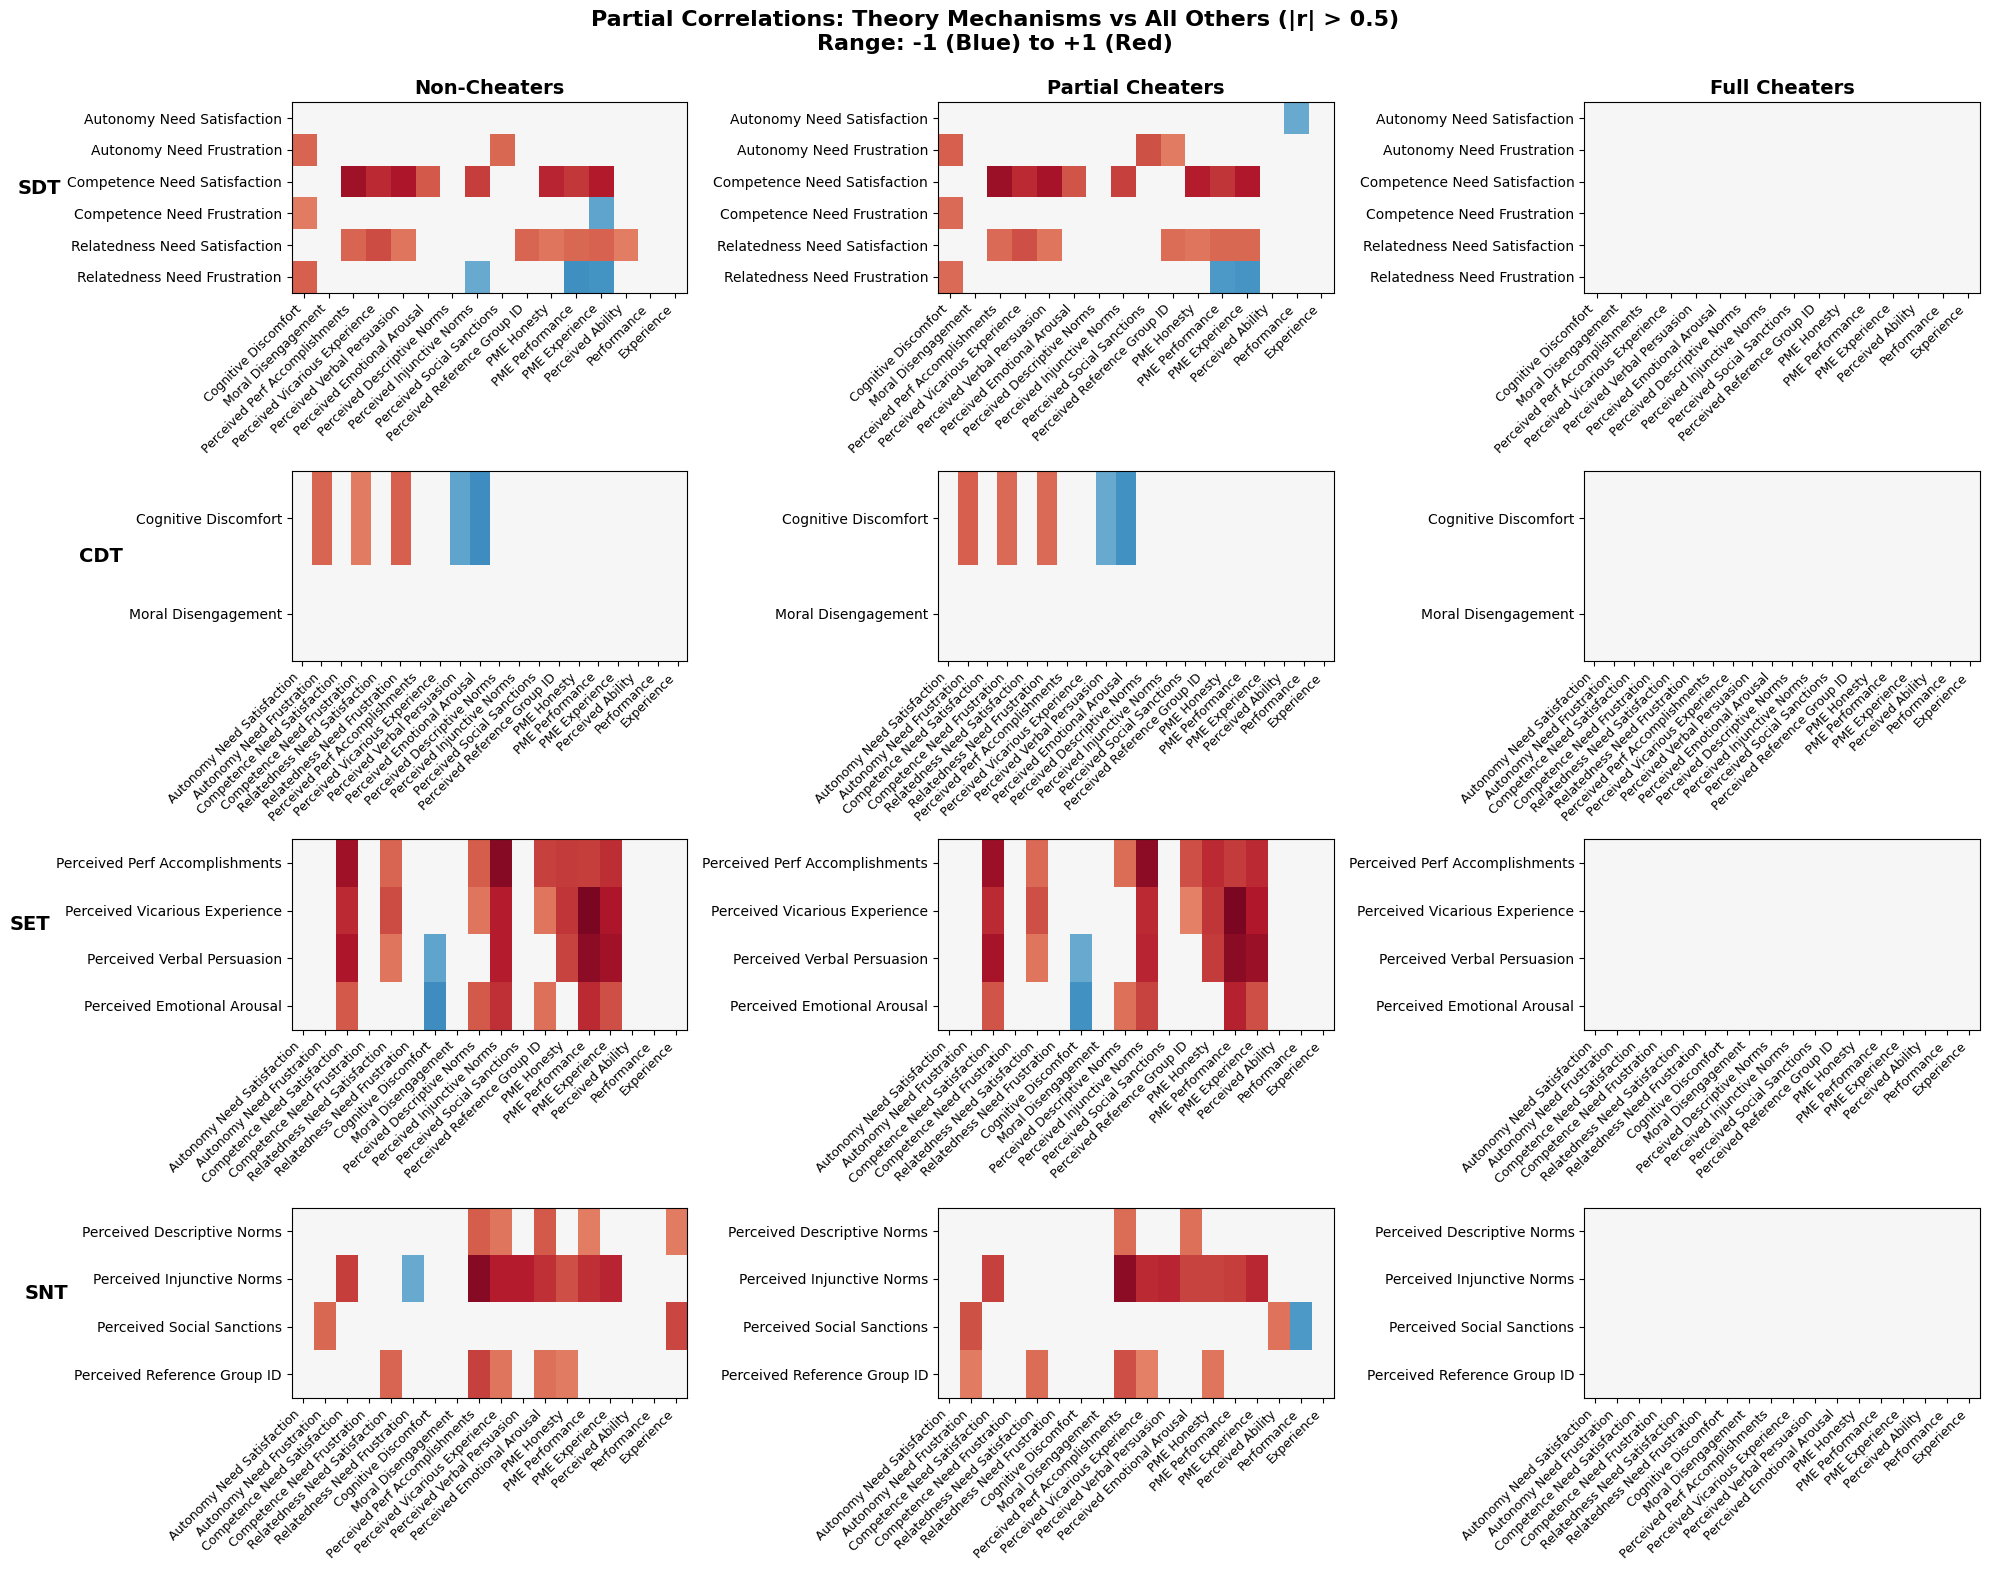

In [44]:
# =============================================================================
# 5. PARTIAL CORRELATIONS ALL INTERMEDIATORY VARIABLES AND OUTCOME 
# DRAW HEATMAPS
# =============================================================================

def compute_partial_corr(data, cv=5, max_iter=1000, alphas=20):
    """Consistent GraphicalLassoCV partial correlation calculation"""
    scaler = StandardScaler()
    data_scaled = pd.DataFrame(
        scaler.fit_transform(data),
        columns=data.columns
    )
    
    try:
        model = GraphicalLassoCV(cv=cv, max_iter=max_iter, alphas=alphas)
        model.fit(data_scaled)
        precision = model.precision_
        diag_sqrt = np.sqrt(np.diag(precision))
        partial_corr = -precision / np.outer(diag_sqrt, diag_sqrt)
        np.fill_diagonal(partial_corr, 0)
        alpha_used = model.alpha_
        
        partial_corr_df = pd.DataFrame(
            partial_corr, 
            index=data.columns, 
            columns=data.columns
        )
        
        return partial_corr_df, alpha_used
    except:
        # Fallback to simple correlation
        partial_corr_df = data_scaled.corr()
        np.fill_diagonal(partial_corr_df.values, 0)
        return partial_corr_df, None


def calculate_and_visualize_partial_correlations(df, posterior_data, threshold=0.3):
    """Compute partial correlations using consistent GraphicalLassoCV method"""
    
    # Full dataset correlation using consistent method
    full_data = pd.DataFrame(posterior_data)
    full_corr_df, alpha = compute_partial_corr(full_data)
    
    if alpha:
        print(f"Full dataset Graphical Lasso alpha: {alpha:.4f}")
    else:
        print("Using Pearson correlation as fallback for full dataset")

    # Identify significant pairs
    sig_pairs = [
        (i, j, full_corr_df.loc[i, j])
        for i in full_corr_df.columns
        for j in full_corr_df.columns
        if i < j and abs(full_corr_df.loc[i, j]) > threshold
    ]
    sig_pairs.sort(key=lambda x: abs(x[2]), reverse=True)

    # Group-specific correlations using consistent method
    def get_group_corr(group_id):
        group_mask = df['cheating_behavior'] == group_id
        group_data = pd.DataFrame({k: v[group_mask] for k, v in posterior_data.items()})
        return compute_partial_corr(group_data, cv=3, max_iter=500, alphas=10)[0]

    # Define theories and names (same as before)
    theories = {
        'SDT': ['autonomy_need_satisfaction', 'autonomy_need_frustration', 
                'competence_need_satisfaction', 'competence_need_frustration',
                'relatedness_need_satisfaction', 'relatedness_need_frustration'],
        'CDT': ['cognitive_discomfort', 'moral_disengagement'],
        'SET': ['performance_accomplishments', 'vicarious_experience', 
                'verbal_persuasion', 'emotional_arousal'],
        'SNT': ['descriptive_norms', 'injunctive_norms', 
                'social_sanctions', 'reference_group_identification']
    }

    other_vars = ['PME_on_honest_task_completion', 'PME_on_task_performance', 
                'PME_on_task_experience', 'perceived_ability', 'performance', 'experience']

    name_map = {
        'autonomy_need_satisfaction': 'Autonomy Need Satisfaction',
        'autonomy_need_frustration': 'Autonomy Need Frustration',
        'competence_need_satisfaction': 'Competence Need Satisfaction',
        'competence_need_frustration': 'Competence Need Frustration',
        'relatedness_need_satisfaction': 'Relatedness Need Satisfaction',
        'relatedness_need_frustration': 'Relatedness Need Frustration',
        'cognitive_discomfort': 'Cognitive Discomfort',
        'moral_disengagement': 'Moral Disengagement',
        'performance_accomplishments': 'Perceived Perf Accomplishments',
        'vicarious_experience': 'Perceived Vicarious Experience',
        'verbal_persuasion': 'Perceived Verbal Persuasion',
        'emotional_arousal': 'Perceived Emotional Arousal',
        'descriptive_norms': 'Perceived Descriptive Norms',
        'injunctive_norms': 'Perceived Injunctive Norms',
        'social_sanctions': 'Perceived Social Sanctions',
        'reference_group_identification': 'Perceived Reference Group ID',
        'PME_on_honest_task_completion': 'PME Honesty',
        'PME_on_task_performance': 'PME Performance',
        'PME_on_task_experience': 'PME Experience',
        'perceived_ability': 'Perceived Ability',
        'performance': 'Performance',
        'experience': 'Experience'
    }

    # Calculate maximum number of mechanisms across theories for consistent sizing
    max_mechanisms = max(len([v for v in vars if v in posterior_data]) 
                        for vars in theories.values())
    
    # Setup plots with adjusted figure size and spacing
    fig, axes = plt.subplots(4, 3, figsize=(20, 18)) 
    group_names = ['Non-Cheaters', 'Partial Cheaters', 'Full Cheaters']

    for t_idx, (theory, row_vars) in enumerate(theories.items()):
        row_vars = [v for v in row_vars if v in posterior_data]
        col_vars = [v for th, vs in theories.items() if th != theory for v in vs if v in posterior_data]
        col_vars += [v for v in other_vars if v in posterior_data]

        for g_idx, group in enumerate(group_names):
            ax = axes[t_idx, g_idx]
            corr_df = get_group_corr(g_idx)  # Using consistent method

            # Apply threshold - only show values above threshold
            mat = np.array([[corr_df.get(row, {}).get(col, 0) if abs(corr_df.get(row, {}).get(col, 0)) > threshold else 0
                            for col in col_vars] for row in row_vars])
            
            # Calculate consistent cell height
            cell_height = max_mechanisms / len(row_vars) if len(row_vars) > 0 else 1
            
            im = ax.imshow(mat, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
            
            # Set ticks and labels
            ax.set_xticks(range(len(col_vars)))
            ax.set_yticks(range(len(row_vars)))
            ax.set_xticklabels([name_map.get(var, var) for var in col_vars], 
                              rotation=45, ha='right', fontsize=9)
            ax.set_yticklabels([name_map.get(var, var) for var in row_vars], 
                              fontsize=10)
            
            # Add correlation values as text for values above threshold
            # for i in range(len(row_vars)):
            #     for j in range(len(col_vars)):
            #         value = mat[i, j]
            #         if abs(value) > threshold:  # Only show values above threshold
            #             text_color = 'white' if abs(value) > 0.5 else 'black'
            #             ax.text(j, i, f'{value:.2f}', ha='center', va='center',
            #                    color=text_color, fontsize=8, fontweight='bold')

            if t_idx == 0:
                ax.set_title(group, fontweight='bold', fontsize=14)
            if g_idx == 0:
                ax.set_ylabel(theory, fontweight='bold', fontsize=14, rotation=0, ha='right')

    plt.tight_layout(rect=[0, 0.1, 1, 0.94])
    
    # Add horizontal colorbar at bottom with proper range
    # cbar = fig.colorbar(im, ax=axes, orientation='horizontal', 
    #                    pad=0.05, shrink=0.8, aspect=50)
    # cbar.set_label('Partial Correlation', fontsize=14, fontweight='bold')
    # cbar.set_ticks([-1, -0.5, 0, 0.5, 1])
    
    plt.suptitle(f'Partial Correlations: Theory Mechanisms vs All Others (|r| > {threshold})\nRange: -1 (Blue) to +1 (Red)',
                fontsize=16, fontweight='bold', y=0.97)
    plt.show()

    return full_corr_df, sig_pairs

    
partial_corr_df, significant_pairs = calculate_and_visualize_partial_correlations(df, posterior_data, threshold=0.5)

In [22]:
# =============================================================================
# 6. NETWORK VISUALIZATION - LAYOUT AND DRAWING
# =============================================================================
def create_rectangular_theory_layout(G, labels, mechanisms, outcomes, other_vars):
    """Organize nodes spatially by theory with consistent ordering"""
    
    pos = {}
    SPACING_X = 0.16
    SPACING_Y = 0.12
    
    # Anchor points
    left_x = 0.05
    right_x = 0.95
    center_x = 0.50
    top_y = 0.92
    bottom_y = 0.08
    
    # Define theory categories with explicit ordering
    sdt_mechanisms = ['autonomy_need_satisfaction', 'autonomy_need_frustration', 
                      'competence_need_satisfaction', 'competence_need_frustration',
                      'relatedness_need_satisfaction', 'relatedness_need_frustration']
    
    cdt_mechanisms = ['cognitive_discomfort', 'moral_disengagement']
    
    # SET with correct order: performance accomplishment, vicarious experience, verbal persuasion, emotional arousal
    set_mechanisms = ['performance_accomplishments', 'vicarious_experience', 
                      'verbal_persuasion', 'emotional_arousal']
    
    # SNT with consistent ordering: descriptive norms first, then injunctive norms
    snt_mechanisms = ['descriptive_norms', 'injunctive_norms', 
                      'social_sanctions', 'reference_group_identification']
    
    pme_mechanisms = ['PME_on_honest_task_completion', 'PME_on_task_performance', 'PME_on_task_experience']
    
    # Center: Primary outcomes (performance, experience)
    primary_outcomes = ['performance', 'experience']
    for i, outcome in enumerate(primary_outcomes):
        if outcome in labels:
            idx = labels.index(outcome)
            pos[idx] = (center_x - 0.05 + i * 0.1, 0.5)
    
    # PME mechanisms (secondary outcomes) - just below center, evenly spaced
    pme_present = [mech for mech in pme_mechanisms if mech in labels]
    if pme_present:
        pme_start_x = center_x - (len(pme_present) - 1) * 0.04
        for i, mechanism in enumerate(pme_present):
            idx = labels.index(mechanism)
            pos[idx] = (pme_start_x + i * 0.08, 0.38)
    
    # Fixed position for perceived_ability (middle-left, between SDT and center)
    if 'perceived_ability' in labels:
        idx = labels.index('perceived_ability')
        pos[idx] = (0.25, 0.5)
    
    # SDT (left side)
    sdt_mechanisms_present = [m for m in sdt_mechanisms if m in labels]
    for i, mechanism in enumerate(sdt_mechanisms_present):
        idx = labels.index(mechanism)
        pos[idx] = (left_x + 0.12, 0.8 - i * SPACING_Y)
    
    # CDT (top)
    cdt_mechanisms_present = [m for m in cdt_mechanisms if m in labels]
    if cdt_mechanisms_present:
        cdt_mech_start_x = center_x - (len(cdt_mechanisms_present) - 1) * SPACING_X / 2
        for i, mechanism in enumerate(cdt_mechanisms_present):
            idx = labels.index(mechanism)
            pos[idx] = (cdt_mech_start_x + i * SPACING_X, top_y - 0.08)
    
    # SET (right side) - with correct ordering
    set_mechanisms_present = [m for m in set_mechanisms if m in labels]
    for i, mechanism in enumerate(set_mechanisms_present):
        idx = labels.index(mechanism)
        pos[idx] = (right_x - 0.12, 0.8 - i * SPACING_Y)
    
    # SNT (bottom) - with consistent ordering
    snt_mechanisms_present = [m for m in snt_mechanisms if m in labels]
    if snt_mechanisms_present:
        snt_mech_start_x = center_x - (len(snt_mechanisms_present) - 1) * SPACING_X / 2
        for i, mechanism in enumerate(snt_mechanisms_present):
            idx = labels.index(mechanism)
            pos[idx] = (snt_mech_start_x + i * SPACING_X, bottom_y + 0.08)
    
    # Handle any remaining variables
    all_positioned = set()
    for mechanism_list in [sdt_mechanisms, cdt_mechanisms, set_mechanisms, snt_mechanisms, pme_mechanisms]:
        all_positioned.update(mechanism_list)
    all_positioned.update(primary_outcomes)
    all_positioned.add('perceived_ability')
    
    remaining_vars = [var for var in labels if var not in all_positioned]
    for i, var in enumerate(remaining_vars):
        idx = labels.index(var)
        pos[idx] = (0.75, 0.3 - i * SPACING_Y)  # Right side, lower area
    
    return pos

In [32]:
# =============================================================================
# 6. NETWORK VISUALIZATION - COLORS AND SIZES OF NODES
# =============================================================================
def get_theory_based_colors_and_sizes(G, labels):
    """Assign colors and sizes based on theory categories"""
    
    node_colors = []
    node_sizes = []
    
    colors = {
        'primary_outcomes': '#EB2FE6',      # Blue
        'pme_mechanisms': '#FF9CFB',        # Light blue
        'sdt_mechanisms': '#aec7e8',        # Light green
        'cdt_mechanisms': '#ffbb78',        # Light purple
        'set_mechanisms': '#c5b0d5',        # Light red
        'snt_mechanisms': '#c49c94',        # Light orange
        'perceived_ability': '#FFFFFF',     # White - fixed color for perceived_ability
        'other': '#34495E'                  # Dark gray
    }
    
    # Define categories for consistent classification
    primary_outcomes = ['performance', 'experience']
    pme_mechanisms = ['PME_on_honest_task_completion', 'PME_on_task_performance', 'PME_on_task_experience']
    
    sdt_mechanisms = ['autonomy_need_satisfaction', 'autonomy_need_frustration', 
                      'competence_need_satisfaction', 'competence_need_frustration',
                      'relatedness_need_satisfaction', 'relatedness_need_frustration']
    
    cdt_mechanisms = ['cognitive_discomfort', 'moral_disengagement']
    
    set_mechanisms = ['performance_accomplishments', 'vicarious_experience', 
                      'verbal_persuasion', 'emotional_arousal']
    
    snt_mechanisms = ['descriptive_norms', 'injunctive_norms', 
                      'social_sanctions', 'reference_group_identification']
    
    for node in G.nodes():
        label = labels[node]
        
        if label in primary_outcomes:
            node_colors.append(colors['primary_outcomes'])
            node_sizes.append(1200)
        elif label in pme_mechanisms:
            node_colors.append(colors['pme_mechanisms'])
            node_sizes.append(700)
        elif label == 'perceived_ability':
            node_colors.append(colors['perceived_ability'])
            node_sizes.append(600)
        elif label in sdt_mechanisms:
            node_colors.append(colors['sdt_mechanisms'])
            node_sizes.append(600)
        elif label in cdt_mechanisms:
            node_colors.append(colors['cdt_mechanisms'])
            node_sizes.append(600)
        elif label in set_mechanisms:
            node_colors.append(colors['set_mechanisms'])
            node_sizes.append(600)
        elif label in snt_mechanisms:
            node_colors.append(colors['snt_mechanisms'])
            node_sizes.append(600)
        else:
            node_colors.append(colors['other'])
            node_sizes.append(500)
    
    return node_colors, node_sizes

In [ ]:
# =============================================================================
# 6. NETWORK VISUALIZATION - LABELS
# =============================================================================
def create_abbreviated_labels(labels):
    """Create abbreviated labels for better readability with consistent naming"""
    
    abbreviations = {
        # Primary outcomes
        'performance': 'Performance',
        'experience': 'Experience',
        
        # PME mechanisms
        'PME_on_honest_task_completion': 'PME on\nHonesty',
        'PME_on_task_performance': 'PME on\nPerformance',
        'PME_on_task_experience': 'PME on\nExperience',
        
        # Perceived ability (fixed)
        'perceived_ability': 'Perceived\nAbility',
        
        # SDT
        'autonomy_need_satisfaction': 'Autonomy\nSatisfaction',
        'autonomy_need_frustration': 'Autonomy\nFrustration',
        'competence_need_satisfaction': 'Competence\nSatisfaction',
        'competence_need_frustration': 'Competence\nFrustration',
        'relatedness_need_satisfaction': 'Relatedness\nSatisfaction',
        'relatedness_need_frustration': 'Relatedness\nFrustration',
        
        # CDT
        'cognitive_discomfort': 'Cognitive\nDiscomfort',
        'moral_disengagement': 'Moral\nDisengagement',
        
        # SET (with correct ordering)
        'performance_accomplishments': 'Perceived Performance\nAccomplishments',
        'vicarious_experience': 'Perceived Vicarious\nExperience',
        'verbal_persuasion': 'Perceived Verbal\nPersuasion',
        'emotional_arousal': 'Perceived Emotional\nArousal',
        
        # SNT (with consistent ordering)
        'descriptive_norms': 'Perceived Descriptive\nNorms',
        'injunctive_norms': 'Perceived Injunctive\nNorms',
        'social_sanctions': 'Perceived Social\nSanctions',
        'reference_group_identification': 'Perceived Reference\nGroup ID',
    }
    
    label_dict = {}
    for i, label in enumerate(labels):
        label_dict[i] = abbreviations.get(label, label.replace('_', ' ').title()[:10])
    
    return label_dict

Full Cheaters Graphical Lasso alpha: 0.0092


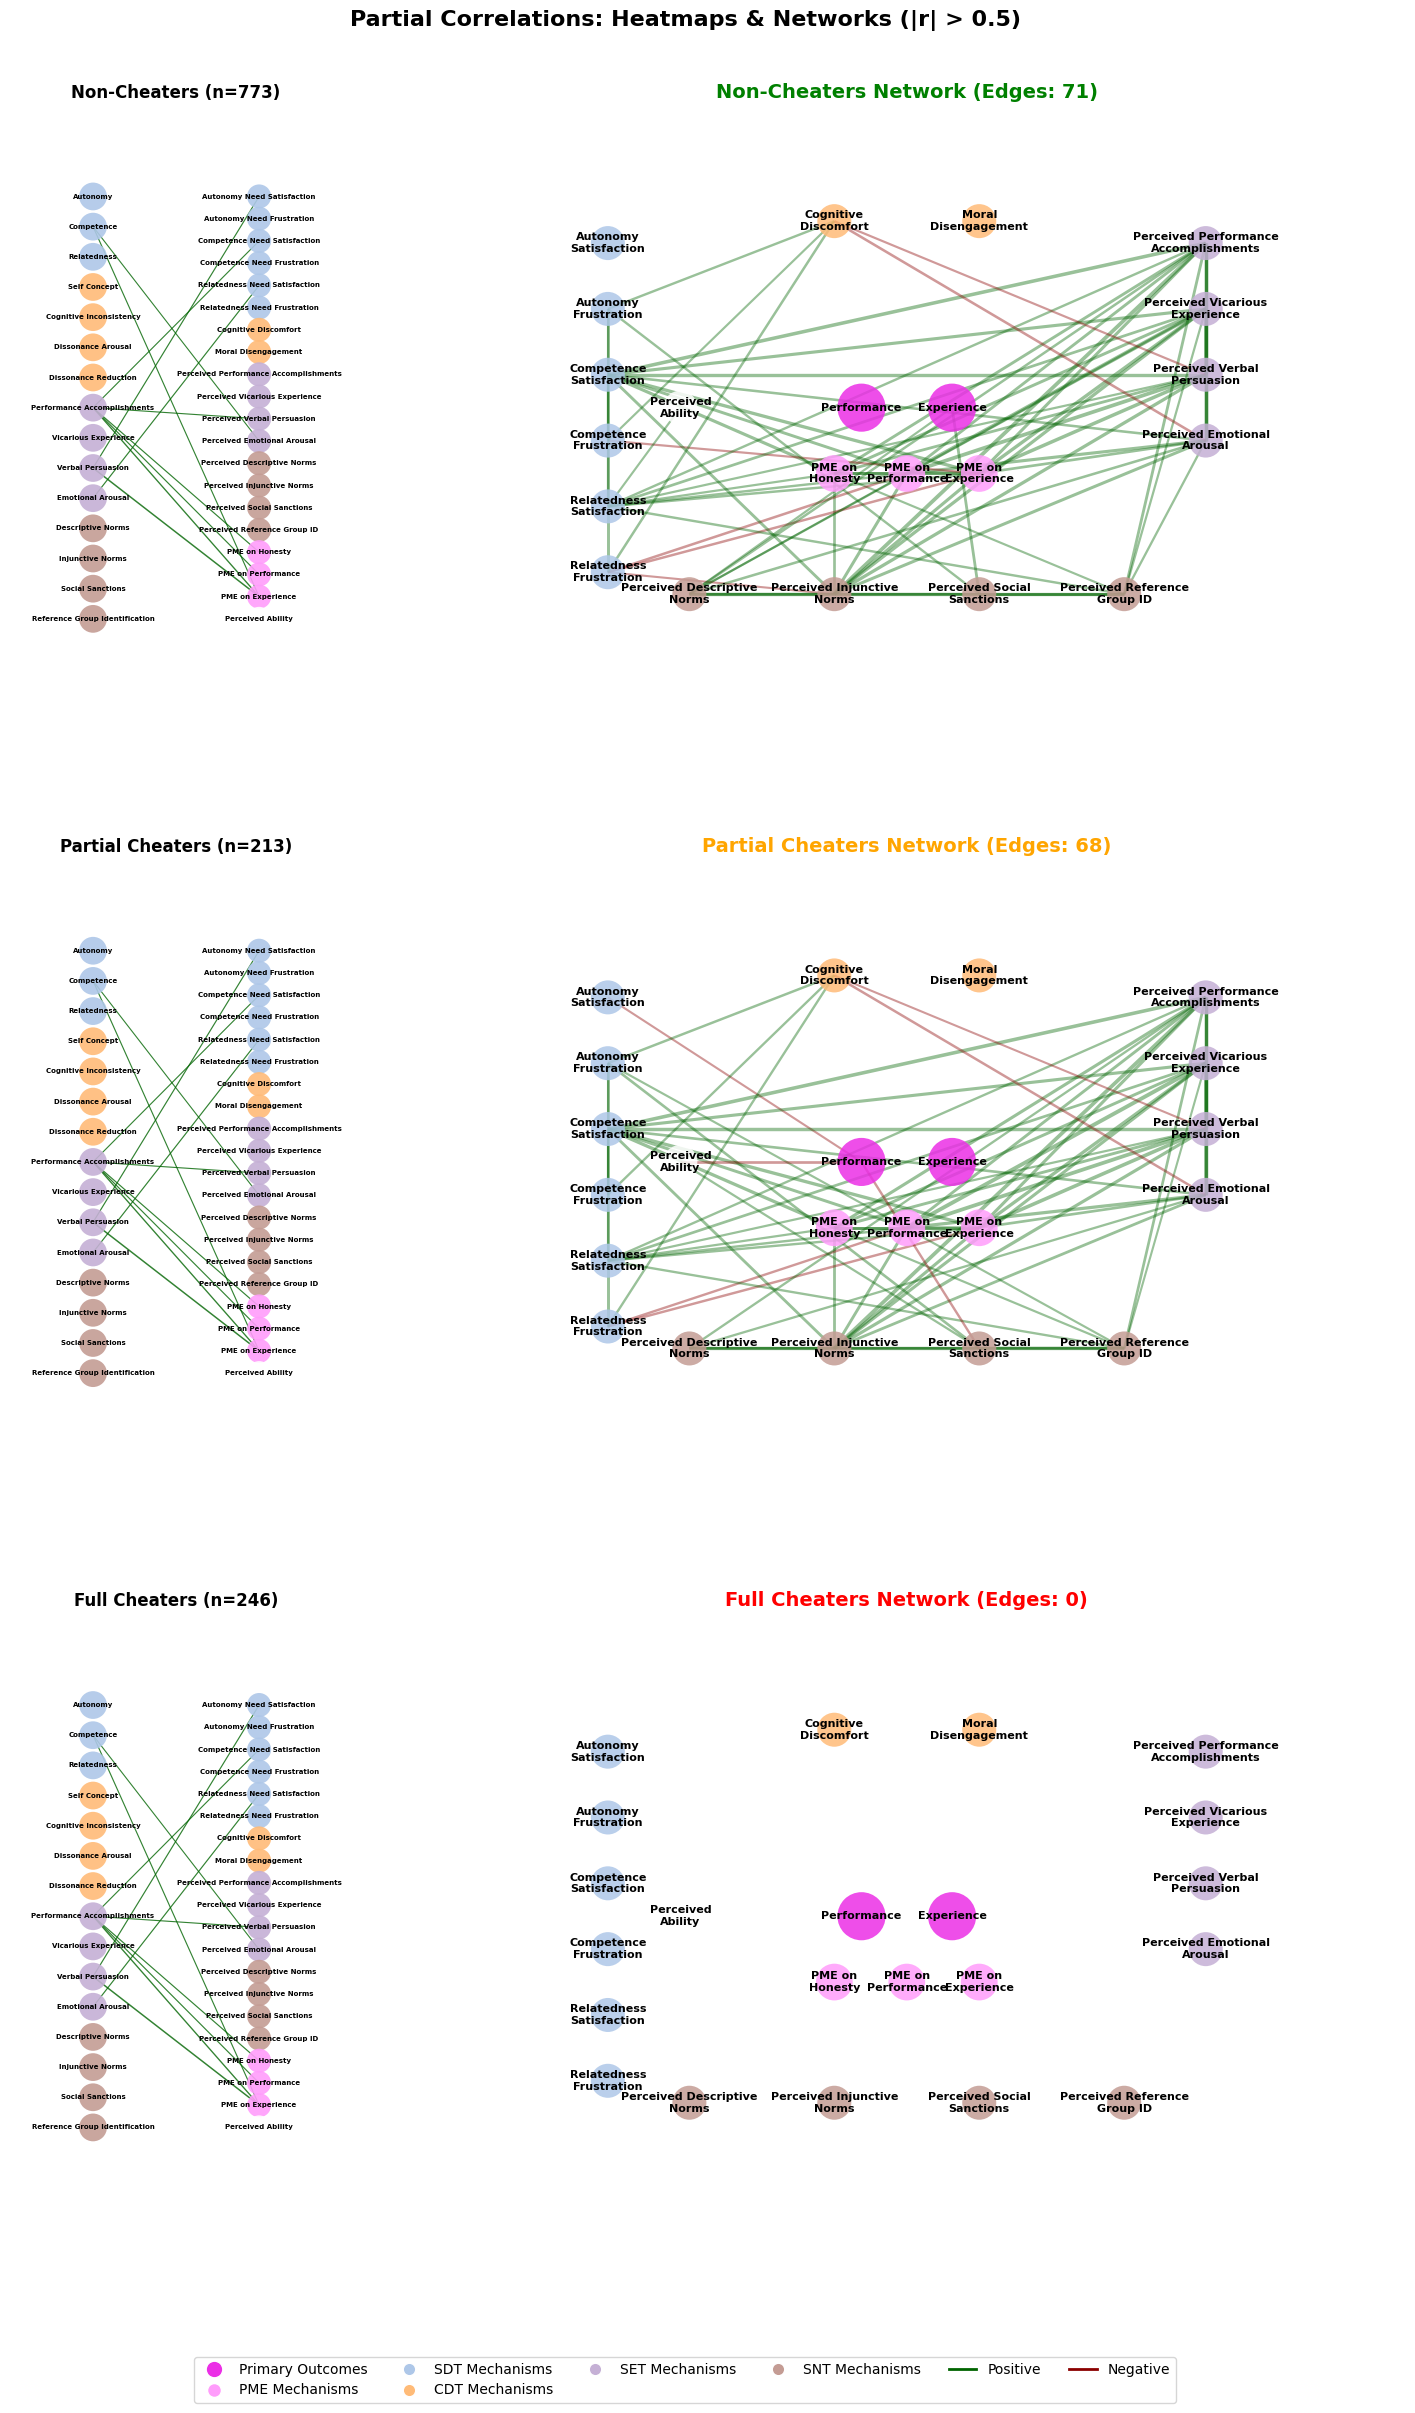

In [ ]:
# =============================================================================
# 6. NETWORK VISUALIZATION: PLOTTING
# =============================================================================

def create_bipartite_for_group(trace_mechanisms, trace_performance, trace_experience, 
                                       concepts, available_mechanisms, df, group_id, ax, group_name):
    """Create bipartite concept->mechanism/outcome network for specific cheating group"""
    
    group_mask = df['cheating_behavior'] == group_id
    if group_mask.sum() < 10:
        ax.text(0.5, 0.5, f'{group_name}\nn={group_mask.sum()}\nToo few', 
                ha='center', va='center', transform=ax.transAxes, fontsize=10)
        ax.set_title(f'{group_name}', fontweight='bold', fontsize=12)
        ax.axis('off')
        return
    
    # Name mapping for mechanisms
    name_map = {
        'autonomy_need_satisfaction': 'Autonomy Need Satisfaction',
        'autonomy_need_frustration': 'Autonomy Need Frustration',
        'competence_need_satisfaction': 'Competence Need Satisfaction',
        'competence_need_frustration': 'Competence Need Frustration',
        'relatedness_need_satisfaction': 'Relatedness Need Satisfaction',
        'relatedness_need_frustration': 'Relatedness Need Frustration',
        'cognitive_discomfort': 'Cognitive Discomfort',
        'moral_disengagement': 'Moral Disengagement',
        'performance_accomplishments': 'Perceived Performance Accomplishments',
        'vicarious_experience': 'Perceived Vicarious Experience',
        'verbal_persuasion': 'Perceived Verbal Persuasion',
        'emotional_arousal': 'Perceived Emotional Arousal',
        'descriptive_norms': 'Perceived Descriptive Norms',
        'injunctive_norms': 'Perceived Injunctive Norms',
        'social_sanctions': 'Perceived Social Sanctions',
        'reference_group_identification': 'Perceived Reference Group ID',
        'PME_on_honest_task_completion': 'PME on Honesty',
        'PME_on_task_performance': 'PME on Performance',
        'PME_on_task_experience': 'PME on Experience',
        'perceived_ability': 'Perceived Ability',
        'performance': 'Performance',
        'experience': 'Experience'
    }
    
    # Theory ordering and colors - SDT from top
    theory_order = [
        'autonomy', 'competence', 'relatedness',  # SDT
        'self_concept', 'cognitive_inconsistency', 'dissonance_arousal', 'dissonance_reduction',  # CDT
        'performance_accomplishments', 'vicarious_experience', 'verbal_persuasion', 'emotional_arousal',  # SET
        'descriptive_norms', 'injunctive_norms', 'social_sanctions', 'reference_group_identification'  # SNT
    ]
    
    theory_colors = {
        'Self-Determination Theory': "#aec7e8",
        'Cognitive Dissonance Theory': '#ffbb78',
        'Self-Efficacy Theory': '#c5b0d5',
        'Social Norms Theory': "#c49c94"
    }
    
    theory_map = {
        'autonomy': 'Self-Determination Theory', 'competence': 'Self-Determination Theory', 'relatedness': 'Self-Determination Theory',
        'self_concept': 'Cognitive Dissonance Theory', 'cognitive_inconsistency': 'Cognitive Dissonance Theory', 
        'dissonance_arousal': 'Cognitive Dissonance Theory', 'dissonance_reduction': 'Cognitive Dissonance Theory',
        'performance_accomplishments': 'Self-Efficacy Theory', 'vicarious_experience': 'Self-Efficacy Theory', 
        'verbal_persuasion': 'Self-Efficacy Theory', 'emotional_arousal': 'Self-Efficacy Theory',
        'descriptive_norms': 'Social Norms Theory', 'injunctive_norms': 'Social Norms Theory', 
        'social_sanctions': 'Social Norms Theory', 'reference_group_identification': 'Social Norms Theory'
    }
    
    # Extract concept->mechanism effects
    concept_to_mech_samples = trace_mechanisms.posterior['concept_to_mechanisms'].values.reshape(-1, len(concepts), len(available_mechanisms))
    mech_effects_mean = concept_to_mech_samples.mean(axis=0)
    
    # Create ordered lists - concepts from top (autonomy first)
    ordered_concepts = [c for c in theory_order if c in concepts]
    
    # Order mechanisms by theory - autonomy_need_satisfaction first
    sdt_mechs = ['autonomy_need_satisfaction', 'autonomy_need_frustration', 
                 'competence_need_satisfaction', 'competence_need_frustration', 
                 'relatedness_need_satisfaction', 'relatedness_need_frustration']
    cdt_mechs = ['cognitive_discomfort', 'moral_disengagement']
    set_mechs = ['performance_accomplishments', 'vicarious_experience', 'verbal_persuasion', 'emotional_arousal']
    snt_mechs = ['descriptive_norms', 'injunctive_norms', 'social_sanctions', 'reference_group_identification']
    pme_mechs = ['PME_on_honest_task_completion', 'PME_on_task_performance', 'PME_on_task_experience']
    other_mechs = ['perceived_ability']
    
    # Only mechanisms and PME - no outcomes
    ordered_right_nodes = []
    for mech_list in [sdt_mechs, cdt_mechs, set_mechs, snt_mechs, pme_mechs, other_mechs]:
        ordered_right_nodes.extend([m for m in mech_list if m in available_mechanisms])
    
    # Create bipartite graph - no outcomes
    G = nx.Graph()
    concept_nodes = [f"concept_{concept}" for concept in ordered_concepts]
    
    G.add_nodes_from(concept_nodes, bipartite=0)
    G.add_nodes_from(ordered_right_nodes, bipartite=1)
    
    # Only concept -> mechanism edges
    threshold = 0.2
    for i, concept in enumerate(concepts):
        for j, mechanism in enumerate(available_mechanisms):
            if abs(mech_effects_mean[i, j]) > threshold:
                G.add_edge(f"concept_{concept}", mechanism, weight=mech_effects_mean[i, j], edge_type='mechanism')
    
    # Layout with theory-based ordering - concepts from top, closer positioning
    pos = {}
    
    # Left side: concepts ordered by theory (autonomy at top), closer to center
    concept_nodes_in_graph = [n for n in G.nodes() if n.startswith('concept_')]
    if concept_nodes_in_graph:
        concept_y = np.linspace(0.85, 0.15, len(concept_nodes_in_graph))  # More vertical space
        for i, node in enumerate(concept_nodes_in_graph):
            pos[node] = (0.25, concept_y[i])  # Moved closer to center
    
    # Right side: mechanisms ordered by theory (SDT at top), closer to center
    right_nodes_in_graph = [n for n in G.nodes() if not n.startswith('concept_')]
    if right_nodes_in_graph:
        right_y = np.linspace(0.85, 0.15, len(right_nodes_in_graph))  # More vertical space
        for i, node in enumerate(right_nodes_in_graph):
            pos[node] = (0.75, right_y[i])  # Moved closer to center
    
    # Draw edges - only green/red for mechanism connections
    if G.edges():
        for u, v, data in G.edges(data=True):
            weight = abs(data['weight'])
            color = 'darkred' if data['weight'] < 0 else 'darkgreen'
            nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=weight * 4, 
                                 edge_color=color, alpha=0.8, ax=ax)
    
    # Draw nodes with theory-based colors - no outcomes
    for node in G.nodes():
        if node.startswith('concept_'):
            concept_name = node.replace('concept_', '')
            theory = theory_map.get(concept_name, 'Other')
            color = theory_colors.get(theory, '#cccccc')
            size = 400
        elif node in pme_mechs:
            color = '#FF9CFB'  # PME color
            size = 300
        else:
            # Find theory for mechanism
            if 'autonomy' in node or 'competence' in node or 'relatedness' in node:
                color = theory_colors['Self-Determination Theory']
            elif 'cognitive' in node or 'moral' in node:
                color = theory_colors['Cognitive Dissonance Theory']
            elif node in set_mechs:
                color = theory_colors['Self-Efficacy Theory']
            elif node in snt_mechs:
                color = theory_colors['Social Norms Theory']
            else:
                color = '#FFFFFF'  # perceived_ability
            size = 300
        
        nx.draw_networkx_nodes(G, pos, nodelist=[node], ax=ax,
                              node_color=color, node_size=size, alpha=0.9, edgecolors='none')  # No borders
    
    # Labels - only concepts and mechanisms
    concept_labels = {node: node.replace('concept_', '').replace('_', ' ').title() 
                      for node in concept_nodes_in_graph}
    other_labels = {node: name_map.get(node, node.replace('_', ' ').title()) 
                    for node in right_nodes_in_graph}
    
    all_labels = {**concept_labels, **other_labels}
    nx.draw_networkx_labels(G, pos, labels=all_labels, ax=ax, font_size=5, font_weight='bold')
    
    ax.set_title(f'{group_name} (n={group_mask.sum()})', fontweight='bold', fontsize=12)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')


def create_combined_visualization(df, posterior_data, available_mechanisms, 
                                           trace_mechanisms, trace_performance, trace_experience, 
                                           concepts, threshold=0.3):
    """Create 3x2 grid with GraphicalLassoCV partial correlations"""
    
    fig = plt.figure(figsize=(18, 24))
    
    # Create subplot grid - width ratio 1:3 for more network space
    gs = fig.add_gridspec(3, 2, width_ratios=[1, 3], hspace=0.25, wspace=0.1)
    
    cheating_groups = [0, 1, 2]
    group_names = ['Non-Cheaters', 'Partial Cheaters', 'Full Cheaters']
    group_colors = ['green', 'orange', 'red']
    
    for idx, (group, name, color) in enumerate(zip(cheating_groups, group_names, group_colors)):
        
        # Left column: bipartite concept->mechanism/outcome (unchanged)
        ax_left = fig.add_subplot(gs[idx, 0])
        create_bipartite_for_group(trace_mechanisms, trace_performance, trace_experience,
                                           concepts, available_mechanisms, df, group, ax_left, name)
        
        # Right column: Mechanism network with partial correlations
        ax_right = fig.add_subplot(gs[idx, 1])
        
        group_mask = df['cheating_behavior'] == group
        if group_mask.sum() < 10:
            ax_right.text(0.5, 0.5, f'{name}\nn={group_mask.sum()}\nToo few observations', 
                         ha='center', va='center', transform=ax_right.transAxes)
            ax_right.set_title(f'{name} Network', color=color, fontweight='bold')
            ax_right.axis('off')
            continue
        
        # Prepare group data
        group_data = pd.DataFrame({var: values[group_mask] for var, values in posterior_data.items()})
        
        # Use GraphicalLassoCV method
        partial_corr_df, alpha_used = compute_partial_corr(group_data, cv=3, max_iter=500, alphas=10)
        
        if alpha_used:
            print(f"{name} Graphical Lasso alpha: {alpha_used:.4f}")
        
        G = nx.Graph()
        labels = list(group_data.columns)
        for i, label in enumerate(labels):
            G.add_node(i, label=label)
        
        mechanisms = [var for var in labels if var in available_mechanisms]
        outcomes = [var for var in labels if var in ['performance', 'experience']]
        other_vars = [var for var in labels if var not in mechanisms + outcomes]
        
        # Create edges using partial correlations
        for i in range(len(labels)):
            for j in range(i + 1, len(labels)):
                partial_corr_value = partial_corr_df.iloc[i, j]
                if abs(partial_corr_value) > threshold:
                    label_i, label_j = labels[i], labels[j]
                    valid_connection = (
                        (label_i in mechanisms and label_j in outcomes) or
                        (label_j in mechanisms and label_i in outcomes) or
                        (label_i in other_vars and (label_j in mechanisms or label_j in outcomes)) or
                        (label_j in other_vars and (label_i in mechanisms or label_i in outcomes)) or
                        (label_i in mechanisms and label_j in mechanisms)
                    )
                    if valid_connection:
                        G.add_edge(i, j, weight=partial_corr_value)
        
        # Add missing nodes
        for i, label in enumerate(labels):
            if i not in G:
                G.add_node(i, label=label)
        
        pos = create_rectangular_theory_layout(G, labels, mechanisms, outcomes, other_vars)
        positioned_nodes = [node for node in G.nodes() if node in pos]
        G_filtered = G.subgraph(positioned_nodes).copy()
        node_colors, node_sizes = get_theory_based_colors_and_sizes(G_filtered, labels)
        
        # Draw network
        if G_filtered.edges():
            edge_weights = [abs(G_filtered[u][v]['weight']) * 3 for u, v in G_filtered.edges()]
            edge_colors = ['darkred' if G_filtered[u][v]['weight'] < 0 else 'darkgreen' 
                          for u, v in G_filtered.edges()]
            nx.draw_networkx_edges(G_filtered, pos, ax=ax_right, width=edge_weights, 
                                  edge_color=edge_colors, alpha=0.4)
        
        nx.draw_networkx_nodes(G_filtered, pos, ax=ax_right, node_color=node_colors, 
                              node_size=node_sizes, alpha=0.85, edgecolors='none', linewidths=1.5)
        
        label_dict = {node: create_abbreviated_labels(labels)[node] for node in G_filtered.nodes()}
        nx.draw_networkx_labels(G_filtered, pos, labels=label_dict, ax=ax_right, 
                               font_size=8, font_weight='bold')
        
        # Title with edge count for verification
        ax_right.set_title(f'{name} Network (Edges: {len(G_filtered.edges())})', 
                          color=color, fontweight='bold', fontsize=14)
        ax_right.set_xlim(-0.05, 1.05)
        ax_right.set_ylim(-0.05, 1.05)
        ax_right.axis('off')
    
    # Updated legend
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#EB2FE6', markersize=12, label='Primary Outcomes'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#FF9CFB', markersize=10, label='PME Mechanisms'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#aec7e8', markersize=9, label='SDT Mechanisms'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#ffbb78', markersize=9, label='CDT Mechanisms'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#c5b0d5', markersize=9, label='SET Mechanisms'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#c49c94', markersize=9, label='SNT Mechanisms'),
        plt.Line2D([0], [0], color='darkgreen', linewidth=2, label='Positive'),
        plt.Line2D([0], [0], color='darkred', linewidth=2, label='Negative'),
    ]
    
    fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.02), 
               ncol=6, fontsize=10, frameon=True)
    
    plt.suptitle(f'Partial Correlations: Heatmaps & Networks (|r| > {threshold})', 
                 fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.subplots_adjust(top=0.94, bottom=0.06)
    plt.show()


threshold = 0.5


create_combined_visualization(df, posterior_data, available_mechanisms, 
                                       trace_mechanisms, trace_performance, trace_experience, 
                                       concepts, threshold=threshold)


In [ ]:
# =============================================================================
# 7. PRINT ALL PARTIAL CORRELATIONS BY CHEATING GROUP
# =============================================================================

def print_correlations_by_group(df, posterior_data, threshold=0.5):
    """Print correlations between mechanisms and outcomes for each cheating group"""
    
    # Define mechanisms and outcomes
    mechanisms = [
        'PME_on_honest_task_completion', 'PME_on_task_performance', 'PME_on_task_experience',
        'autonomy_need_satisfaction', 'autonomy_need_frustration',
        'competence_need_satisfaction', 'competence_need_frustration', 
        'relatedness_need_satisfaction', 'relatedness_need_frustration',
        'performance_accomplishments', 'vicarious_experience', 'verbal_persuasion', 'emotional_arousal',
        'descriptive_norms', 'injunctive_norms', 'social_sanctions', 'reference_group_identification',
        'cognitive_discomfort', 'moral_disengagement', 'perceived_ability'
    ]
    
    outcomes = ['performance', 'experience']
    
    # Filter available variables
    available_mechanisms = [m for m in mechanisms if m in posterior_data]
    available_outcomes = [o for o in outcomes if o in posterior_data]
    
    # Name mapping
    name_map = {
        'PME_on_honest_task_completion': 'PME Honesty',
        'PME_on_task_performance': 'PME Performance', 
        'PME_on_task_experience': 'PME Experience',
        'autonomy_need_satisfaction': 'Autonomy Need Satisfaction',
        'autonomy_need_frustration': 'Autonomy Need Frustration',
        'competence_need_satisfaction': 'Competence Need Satisfaction',
        'competence_need_frustration': 'Competence Need Frustration',
        'relatedness_need_satisfaction': 'Relatedness Need Satisfaction',
        'relatedness_need_frustration': 'Relatedness Need Frustration',
        'performance_accomplishments': 'Perceived Performance Accomplishments',
        'vicarious_experience': 'Perceived Vicarious Experience',
        'verbal_persuasion': 'Perceived Verbal Persuasion',
        'emotional_arousal': 'Perceived Emotional Arousal',
        'descriptive_norms': 'Perceived Descriptive Norms',
        'injunctive_norms': 'Perceived Injunctive Norms',
        'social_sanctions': 'Perceived Social Sanctions',
        'reference_group_identification': 'Perceived Reference Group ID',
        'cognitive_discomfort': 'Cognitive Discomfort',
        'moral_disengagement': 'Moral Disengagement',
        'perceived_ability': 'Perceived Ability',
        'performance': 'Performance',
        'experience': 'Experience'
    }
    
    group_names = ['NON-CHEATERS', 'PARTIAL CHEATERS', 'FULL CHEATERS']
    
    for group_id, group_name in enumerate(group_names):
        group_mask = df['cheating_behavior'] == group_id
        n_participants = group_mask.sum()
        
        print(f"\n{group_name} (n={n_participants})")
        print(f"Significant correlations (≥{threshold}) are marked with ** [moderate to large effect]")
        print("=" * 90)
        print(f"{'Variable 1':<40} {'Variable 2':<40} {'Correlation':<12} {'Status'}")
        print("-" * 90)
        
        if n_participants < 10:
            print("Too few observations for reliable correlations")
            continue
            
        # Get group data and compute correlations
        group_data = pd.DataFrame({k: v[group_mask] for k, v in posterior_data.items()})
        
        # Use consistent GraphicalLassoCV method
        try:
            scaler = StandardScaler()
            group_data_scaled = pd.DataFrame(scaler.fit_transform(group_data), columns=group_data.columns)
            
            model = GraphicalLassoCV(cv=3, max_iter=500, alphas=10)
            model.fit(group_data_scaled)
            precision = model.precision_
            diag_sqrt = np.sqrt(np.diag(precision))
            partial_corr = -precision / np.outer(diag_sqrt, diag_sqrt)
            np.fill_diagonal(partial_corr, 0)
            
            corr_df = pd.DataFrame(partial_corr, index=group_data.columns, columns=group_data.columns)
            
        except:
            # Fallback to simple correlation
            corr_df = group_data.corr()
            np.fill_diagonal(corr_df.values, 0)
        
        # Find mechanism-outcome correlations
        correlations = []
        
        # Mechanism to outcome correlations
        for mech in available_mechanisms:
            for outcome in available_outcomes:
                if mech in corr_df.columns and outcome in corr_df.columns:
                    corr_val = corr_df.loc[mech, outcome]
                    correlations.append((mech, outcome, corr_val))
        
        # Mechanism to mechanism correlations  
        for i, mech1 in enumerate(available_mechanisms):
            for mech2 in available_mechanisms[i+1:]:
                if mech1 in corr_df.columns and mech2 in corr_df.columns:
                    corr_val = corr_df.loc[mech1, mech2]
                    correlations.append((mech1, mech2, corr_val))
        
        # Sort by absolute correlation strength
        correlations.sort(key=lambda x: abs(x[2]), reverse=True)
        
        # Print correlations above 0.1, mark those ≥0.5 with **
        found_any = False
        for var1, var2, corr in correlations:
            if abs(corr) >= 0.1:
                found_any = True
                var1_name = name_map.get(var1, var1.replace('_', ' ').title())
                var2_name = name_map.get(var2, var2.replace('_', ' ').title())
                status = '**' if abs(corr) >= 0.5 else ''
                print(f"{var1_name:<40} {var2_name:<40} {corr:+.3f}{'':<8} {status}")
        
        if not found_any:
            print("No correlations found above 0.1")


print_correlations_by_group(df, posterior_data, threshold=0.5)


NON-CHEATERS (n=773)
Significant correlations (≥0.5) are marked with ** [moderate to large effect]
Variable 1                               Variable 2                               Correlation  Status
------------------------------------------------------------------------------------------
PME Performance                          Perceived Vicarious Experience           +0.940         **
Perceived Vicarious Experience           Perceived Verbal Persuasion              +0.928         **
Perceived Performance Accomplishments    Perceived Injunctive Norms               +0.907         **
PME Performance                          Perceived Verbal Persuasion              +0.893         **
PME Performance                          PME Experience                           +0.854         **
Competence Need Satisfaction             Perceived Performance Accomplishments    +0.850         **
PME Experience                           Perceived Verbal Persuasion              +0.843         **
Perceiv

In [ ]:
def print_correlations_by_cheater_groups(df, posterior_data, available_mechanisms, min_threshold=0.05):
    """Print partial correlations for each cheating behavior group"""
    
    # Define clear labels
    variable_labels = {
        # Primary outcomes
        'performance': 'Performance',
        'experience': 'Experience',
        
        # PME mechanisms
        'PME_on_honest_task_completion': 'PME Honesty',
        'PME_on_task_performance': 'PME Performance',
        'PME_on_task_experience': 'PME Experience', 
        
        # Perceived ability
        'perceived_ability': 'Perceived Ability',
        
        # SDT
        'concept_autonomy': 'Autonomy',
        'concept_competence': 'Competence',
        'concept_relatedness': 'Relatedness',
        'autonomy_need_satisfaction': 'Autonomy Need Satisfaction',
        'autonomy_need_frustration': 'Autonomy Need Frustration',
        'competence_need_satisfaction': 'Competence Need Satisfaction',
        'competence_need_frustration': 'Competence Need Frustration',
        'relatedness_need_satisfaction': 'Relatedness Need Satisfaction',
        'relatedness_need_frustration': 'Relatedness Need Frustration',
        
        # CDT
        'concept_self_concept': 'Self Concept',
        'concept_cognitive_inconsistency': 'Cognitive Inconsistency',
        'concept_dissonance_arousal': 'Dissonance Arousal',
        'concept_dissonance_reduction': 'Dissonance Reduction',
        'cognitive_discomfort': 'Cognitive Discomfort',
        'moral_disengagement': 'Moral Disengagement',
        
        # SET
        'concept_performance_accomplishments': 'Performance Accomplishments',
        'concept_vicarious_experience': 'Vicarious Experience',
        'concept_verbal_persuasion': 'Verbal Persuasion',
        'concept_emotional_arousal': 'Emotional Arousal',
        'performance_accomplishments': 'Perceived Performance Accomplishments',
        'vicarious_experience': 'Perceived Vicarious Experience',
        'verbal_persuasion': 'Perceived Verbal Persuasion',
        'emotional_arousal': 'Perceived Emotional Arousal',
        
        # SNT
        'concept_descriptive_norms': 'Descriptive Norms',
        'concept_injunctive_norms': 'Injunctive Norms',
        'concept_social_sanctions': 'Social Sanctions',
        'concept_reference_group_identification': 'Reference Group ID',
        'descriptive_norms': 'Perceived Descriptive Norms',
        'injunctive_norms': 'Perceived Injunctive Norms',
        'social_sanctions': 'Perceived Social Sanctions',
        'reference_group_identification': 'Perceived Reference Group ID',
    }
    
    cheating_groups = [0, 1, 2]
    group_names = ['Non-Cheaters', 'Partial Cheaters', 'Full Cheaters']
    
    for group, name in zip(cheating_groups, group_names):
        group_mask = df['cheating_behavior'] == group
        
        if group_mask.sum() < 10:
            print(f"\n{name}: Too few observations (n={group_mask.sum()})")
            continue
            
        # Prepare group data (exclude non_cheating_prob)
        group_data = pd.DataFrame({
            var: values[group_mask] for var, values in posterior_data.items()
            if var != 'non_cheating_prob'
        })
        
        # Calculate partial correlations
        scaler = StandardScaler()
        group_data_scaled = pd.DataFrame(scaler.fit_transform(group_data), columns=group_data.columns)
        
        try:
            model = GraphicalLassoCV(cv=3, max_iter=500, alphas=10)
            model.fit(group_data_scaled)
            precision = model.precision_
            diag_sqrt = np.sqrt(np.diag(precision))
            partial_corr = -precision / np.outer(diag_sqrt, diag_sqrt)
            np.fill_diagonal(partial_corr, 0)
        except:
            partial_corr = group_data_scaled.corr().values
            np.fill_diagonal(partial_corr, 0)
        
        partial_corr_df = pd.DataFrame(partial_corr, index=group_data.columns, columns=group_data.columns)
        
        # Extract correlations (exclude concept-concept pairs)
        correlations = []
        for i in range(len(partial_corr_df.columns)):
            for j in range(i+1, len(partial_corr_df.columns)):
                var1 = partial_corr_df.columns[i]
                var2 = partial_corr_df.columns[j]
                corr_val = partial_corr_df.iloc[i, j]
                
                # Skip concept-concept correlations
                if var1.startswith('concept_') and var2.startswith('concept_'):
                    continue
                    
                if abs(corr_val) > min_threshold:
                    correlations.append((var1, var2, corr_val))
        
        correlations.sort(key=lambda x: abs(x[2]), reverse=True)
        
        # Print results
        print(f"\n{name.upper()} (n={group_mask.sum()})")
        print("Significant correlations (≥0.5) are marked with ** [moderate to large effect]")
        print("="*90)
        print(f"{'Variable 1':<35} {'Variable 2':<35} {'Correlation':<12} {'Status':<10}")
        print("-"*90)
        
        for var1, var2, corr in correlations:
            var1_clean = variable_labels.get(var1, var1.replace('_', ' ').title())
            var2_clean = variable_labels.get(var2, var2.replace('_', ' ').title())
            status = "**" if abs(corr) >= 0.5 else ""
            print(f"{var1_clean:<35} {var2_clean:<35} {corr:+.3f}       {status}")
        
        print(f"\nTotal correlations: {len(correlations)}")
        print(f"Significant (≥0.5): {len([x for x in correlations if abs(x[2]) >= 0.5])}")
        if correlations:
            print(f"Strongest positive: {max([x[2] for x in correlations if x[2] > 0], default=0):.3f}")
            print(f"Strongest negative: {min([x[2] for x in correlations if x[2] < 0], default=0):.3f}")

# Call the function (add this after posterior_data is created)
print_correlations_by_cheater_groups(df, posterior_data, available_mechanisms, min_threshold=0.05)


NON-CHEATERS (n=773)
Significant correlations (≥0.5) are marked with ** [moderate to large effect]
Variable 1                          Variable 2                          Correlation  Status    
------------------------------------------------------------------------------------------
PME Performance                     Perceived Vicarious Experience      +0.940       **
Perceived Vicarious Experience      Perceived Verbal Persuasion         +0.928       **
Perceived Performance Accomplishments Perceived Injunctive Norms          +0.907       **
PME Performance                     Perceived Verbal Persuasion         +0.893       **
PME Performance                     PME Experience                      +0.854       **
Competence Need Satisfaction        Perceived Performance Accomplishments +0.850       **
PME Experience                      Perceived Verbal Persuasion         +0.843       **
Perceived Verbal Persuasion         Perceived Emotional Arousal         +0.835       **
Perce